# Setting up our workspace

#### Importing the necessary libraries

In [12]:
from importlib import reload
# custom functions 
import helper_functions as hf

import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import pandas as pd
import seaborn as sns

import scipy.stats as scs
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
np.random.seed(45)

import warnings
warnings.filterwarnings('ignore')
reload(hf )

<module 'helper_functions' from 'C:\\Users\\Owner\\Desktop\\Data Science\\Flatiron_Projects\\dsc-mod-3-project-online-ds-ft-090919\\helper_functions.py'>

#### Setting up the connection to the database

In [13]:
# Setting up the connection to the database
conn, cursor = hf.connection()

In [14]:
hf.get_tables(cursor)

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

# Q4 - Are sales related to Employee location?

H0 - Employee Region does __NOT__ have a statistically significant effect on sales.<br>
HA - Employee Region __DOES__ have a statistically significant effect on sales.

In [15]:
query = """select e.country, od.unitprice, od.quantity, od.discount,
           ((od.unitprice * (1-od.discount))*od.quantity) as totalprice
           from employee e
           join [order] o on e.id=o.employeeid
           join orderdetail od on od.orderid=o.id
"""
df = hf.query_to_df(query, conn)
df.head()

,Country,UnitPrice,Quantity,Discount,totalprice
0,UK,14.0,12,0.0,168.0
1,UK,9.8,10,0.0,98.0
2,UK,34.8,5,0.0,174.0
3,UK,18.6,9,0.0,167.4
4,UK,42.4,40,0.0,1696.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
Country       2155 non-null object
UnitPrice     2155 non-null float64
Quantity      2155 non-null int64
Discount      2155 non-null float64
totalprice    2155 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 84.3+ KB


In [17]:
df.Country.unique()

array(['UK', 'USA'], dtype=object)

In [18]:
df.replace(to_replace='UK', value=2, inplace=True)
df.replace(to_replace='USA', value=1, inplace=True)
df.Country = df.Country.astype(int)
df.head(10)

,Country,UnitPrice,Quantity,Discount,totalprice
0,2,14.0,12,0.00,168.00
1,2,9.8,10,0.00,98.00
2,2,34.8,5,0.00,174.00
3,2,18.6,9,0.00,167.40
4,2,42.4,40,0.00,1696.00
5,1,7.7,10,0.00,77.00
6,1,42.4,35,0.15,1261.40
7,1,16.8,15,0.15,214.20
8,1,16.8,6,0.05,95.76
9,1,15.6,15,0.05,222.30


In [19]:
df.describe()

,Country,UnitPrice,Quantity,Discount,totalprice
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,1.263573,26.218520,23.812993,0.056167,587.374960
std,0.440673,29.827418,19.022047,0.083450,969.224235
min,1.000000,2.000000,1.000000,0.000000,4.800000
25%,1.000000,12.000000,10.000000,0.000000,147.000000
50%,1.000000,18.400000,20.000000,0.000000,337.750000
75%,2.000000,32.000000,30.000000,0.100000,656.000000
max,2.000000,263.500000,130.000000,0.250000,15810.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A6026C278>,
      dtype=object)

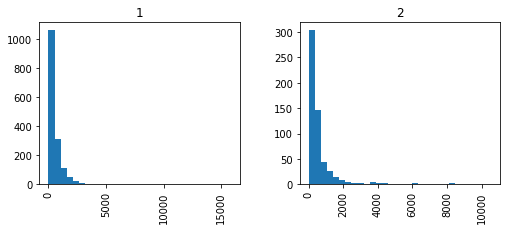

In [20]:
df.hist('totalprice', by='Country', figsize=(8,3), bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A602905C0>]],
      dtype=object)

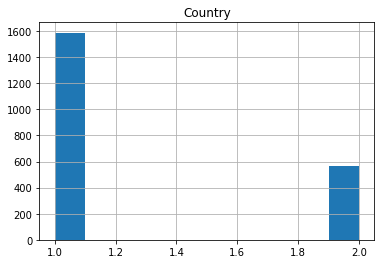

In [21]:
df.hist('Country')

It looks like there may be a difference in the two countries.  We will investigate further.
Let's begin by checking to see if the data is normally distributed.

In [22]:
# First we will separate by country
usa = df.loc[df['Country'] == 1]
eu = df.loc[df['Country'] == 2]

# now to isolate the data we need
usa = usa['totalprice']
eu = eu['totalprice']
control = df['totalprice']

print('USA')
print(hf.test_normality(usa))
print('EU')
print(hf.test_normality(eu))
print('Control')
print(hf.test_normality(control))


USA
p= 0.0
 The data is not normally distributed.
False
EU
p= 3.674442457886974e-37
 The data is not normally distributed.
False
Control
p= 0.0
 The data is not normally distributed.
False


Since the data is not normally distributed, we will use a sampling distribution for our tests.

In [23]:
usa_mean = np.mean(usa)
usa_std = np.std(usa, ddof=1)

samp_usa = np.random.normal(loc=usa_mean, scale=usa_std, size=100)

eu_mean = np.mean(eu)
eu_std = np.std(eu, ddof=1)

samp_eu = np.random.normal(loc=eu_mean, scale=eu_std, size=100)

control_mean = np.mean(control)
control_std = np.std(control, ddof=1)

samp_control = np.random.normal(loc=control_mean, scale=control_std, size=100)

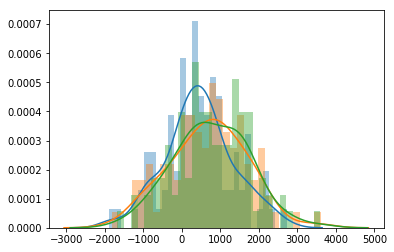

In [24]:
sns.distplot(samp_usa, bins=30)
sns.distplot(samp_eu, bins=30)
sns.distplot(samp_control, bins=30)


The data looks more normal.  Lets check it again with the Shapiro test

In [25]:
hf.test_normality(samp_usa)
hf.test_normality(samp_eu)
hf.test_normality(samp_control)

p= 0.748724639415741
 The data is normally distributed.
p= 0.9128118753433228
 The data is normally distributed.
p= 0.954570472240448
 The data is normally distributed.


True

Lets make sure our data have equal variances using the Levene test.

In [26]:
hf.test_equal_variance(samp_eu, samp_usa)

p= 0.17462714729832532
 Variances are equal.


True

In [28]:
t1, p1 = scs.ttest_ind(samp_control, samp_eu)
print(t1, p1)
t2, p2 = scs.ttest_ind(samp_control, samp_usa)
print(t2, p2)
t3, p3 = scs.ttest_ind(samp_eu, samp_usa)
print(t3, p3)


0.6054643436333149 0.5455638709793627
2.4211301935427185 0.01637417069325561
1.741486661700414 0.08315140707168937


With a p value of .74, this tells us that region does have a significant relationship with sales.<br>
Now we will check the effect size and power of our data.<br>
Lets Visualize the data first to see if it looks like a significant difference

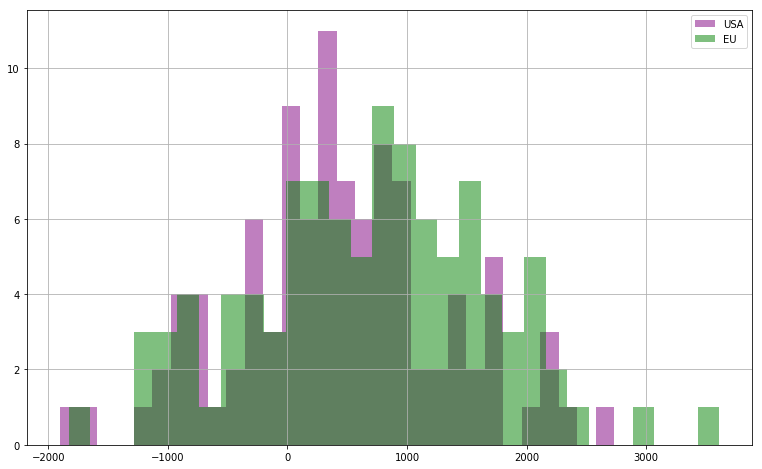

In [29]:
hf.get_hist(samp_usa, samp_eu, label1='USA', label2='EU')

In [30]:
e_size = hf.calc_effect(samp_control, samp_usa)
e_size

0.3423995155979109

In [31]:
power = tt_ind_solve_power(effect_size=e_size, nobs1=100, alpha=.05)
power

0.673437897984443

#### Conclusion
- The effect size and the power here tell us that there is a relationship between sales and region,<br>
- Employees in the USA have a greater effect on total sales than the overall sales in general
Thus, we __reject the null H0__


#### Recommendations: 
* Focus on the team in the USA, they have higher sales than the others.
* USA may be a good candidate for training new employees.
